# Machine learning for Transformer Health Index Analysis

<p style="background-color:azure;padding:10px;border:2px solid lightsteelblue"><b>Author:</b> Petar Sarajcev, PhD (petar.sarajcev@fesb.hr)
<br>
University of Split, FESB, Department of Power Engineering <br>R. Boskovica 32, HR-21000 Split, Croatia, EU.</p>

In [1]:
from __future__ import print_function

In [2]:
import warnings
import exceptions as ex

In [3]:
# Ignore warnings
warnings.filterwarnings(action='ignore', category=ex.FutureWarning)

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score

In [6]:
# Artifical Neural Networks
import keras

Using TensorFlow backend.


In [7]:
# Inline figures
%matplotlib inline

In [8]:
# Figure aesthetics
sns.set(context='notebook', style='white', font_scale=1.2)
sns.set_style('ticks', {'xtick.direction':'in', 'ytick.direction':'in'})

### Transformer diagnostic data and health index values

Transformer diagnostic tests are described in terms of the following six parameters:
* Water (ppm)
* Acidity (mgKOH/g)
* DBV (kV)
* Dissipation factor (%)
* TDCG (ppm)
* Furan (mg/L)

with following meaning: water content in the transformer oil in ppm (Water), total acidity of the oil in mgKOH/g (Acidity), dissolved combustible gases in ppm (TDCG), oil breakdown voltage in kV (DBV), dissipation factor in percent (DF), and 2-Furfuraldehyde content in mg/L (Furan).

In [9]:
data = pd.read_csv('Health_index.csv')
data.drop(labels=['No.', 'AMHA-S', 'AMHA', 'Fuzzy-S', 'Fuzzy', 'LogReg-S', 'LogReg'], axis=1, inplace=True)
data

,Water,Acidity,DBV,DF,TDCG,Furan,GRNN-S,GRNN
0,21.7,0.024,32.5,0.075,483,0.86,0.370,G
1,26.9,0.098,40.5,0.894,254,0.65,0.560,M
2,14.5,0.033,58.0,0.140,78,0.26,0.047,VG
3,21.2,0.226,48.7,0.424,215,5.53,0.780,B
4,10.0,0.010,75.0,0.111,126,0.06,0.030,VG
5,15.5,0.075,71.0,0.143,38,0.53,0.085,VG
6,16.8,0.167,70.1,0.255,149,0.78,0.316,G
7,15.0,0.092,67.8,0.211,28,0.69,0.133,VG
8,17.0,0.035,62.7,0.113,9,0.21,0.040,VG
9,30.0,0.088,37.6,0.353,197,0.31,0.586,M


In [10]:
data['GRNN'].value_counts()/data['GRNN'].value_counts().sum()

VG    0.300000
G     0.233333
B     0.200000
M     0.166667
VB    0.100000
Name: GRNN, dtype: float64

In [11]:
# Correcting outlier with the median value of the data
median = np.percentile(data['DF'], q=50)
data.set_value(18, 'DF', median)
data.iloc[17:20]

,Water,Acidity,DBV,DF,TDCG,Furan,GRNN-S,GRNN
17,23.6,0.070,39.2,0.203,22,0.50,0.406,G
18,30.5,0.073,28.7,0.205,30,1.70,0.790,B
19,18.4,0.063,64.5,0.243,69,0.15,0.119,VG


In [12]:
# Column names
values = ['Water', 'Acidity', 'DBV', 'DF', 'TDCG', 'Furan']
values_all = ['Water', 'Acidity', 'DBV', 'DF', 'TDCG', 'Furan', 'GRNN-S']

In [13]:
warnings.filterwarnings(action='ignore', category=ex.UserWarning)

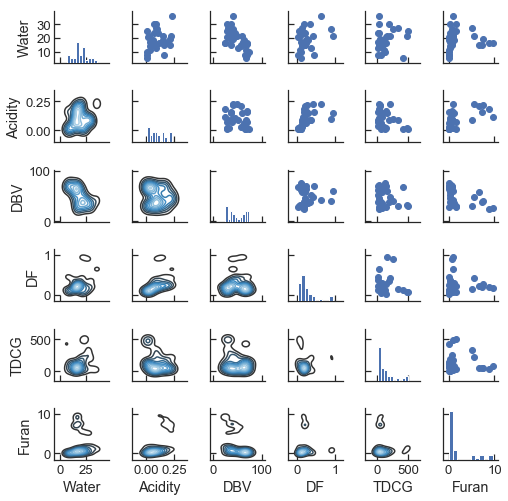

In [14]:
g = sns.PairGrid(data[values], size=1.2)  # size in inches?!
g.map_upper(plt.scatter);
g.map_lower(sns.kdeplot, cmap='Blues_d');
g.map_diag(plt.hist);

### Pearson's correlation matrix (Predictivity)

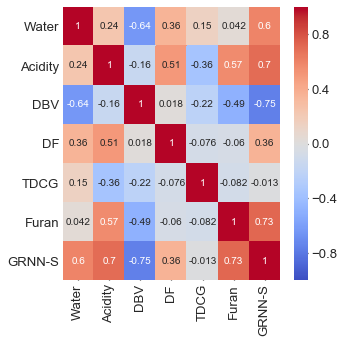

In [15]:
# Predictivity (Pearson correlation matrix)
pearson = data[values_all].corr('pearson')
# Correlation matrix as heatmap (seaborn)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(pearson, annot=True, annot_kws=dict(size=10), vmin=-1, vmax=1, cmap=plt.cm.coolwarm, ax=ax)
plt.tight_layout()
plt.show()

### Generate syntetic transformer data

In [16]:
# Generate synthetic data using the "data augmentation" technique
def trafo_measurements(df, num=100, fraction=0.1):
    data = {}
    idxmax = len(df.index)
    ranvals = np.random.randint(low=0, high=idxmax, size=num)
    for name in df.columns:
        if name == 'GRNN-S':
            data[name] = df[name].iloc[ranvals]
        else:
            sd = df[name].std()
            datavals = df[name].iloc[ranvals].values
            ransigns = np.random.choice([-1., 1.], size=num, replace=True)
            synvalues = datavals + ransigns*(sd*fraction)
            values = np.empty_like(synvalues)
            for i, val in enumerate(synvalues):
                if val > 0. or val is not np.NaN:
                    values[i] = val
                else:
                    values[i] = datavals[i]
            data[name] = np.round(values, decimals=3)
    data = pd.DataFrame(data, columns=df.columns)
    return data

Health Index values:
VB = 4 -> Very bad
 B = 3 -> Bad
 M = 2 -> Moderate
 G = 1 -> Good
VG = 0 -> Very good 

In [17]:
def from_descr_to_score(description):
    if description == 'VB':
        score = 4
    elif description == 'B':
        score = 3
    elif description == 'M':
        score = 2
    elif description == 'G':
        score = 1
    elif description == 'VG':
        score = 0
    else:
        score = None
        raise ValueError('Invalid class label {} encountered!'.format(description))
    return score

def from_score_to_descr(score):
    if score <= 0.2:
        description = 'VG'
    elif 0.2 < score <= 0.4:
        description = 'G'
    elif 0.4 < score <= 0.6:
        description = 'M'
    elif 0.6 < score <= 0.8:
        description = 'B'
    elif 0.8 < score:
        description = 'VB'
    else:
        description = None
        raise ValueError('Score value {} is outside the intended range [0-1]!'.format(score))
    return description

def from_class_to_label(cl):
    if cl == 4:
        label = 'VB'
    elif cl == 3:
        label = 'B'
    elif cl == 2:
        label = 'M'
    elif cl == 1:
        label = 'G'
    elif cl == 0:
        label = 'VG'
    else:
        label = None
        raise ValueError('Invalid class index {} encountered!'.format(cl))
    return label

In [18]:
# ancilary function from: https://github.com/amueller/introduction_to_ml_with_python/blob/master/mglearn/tools.py
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

In [19]:
# Generate syntetic data using "data augmentation"
syntetic = trafo_measurements(data[values_all], num=100)
syntetic['GRNN'] = syntetic['GRNN-S'].apply(from_score_to_descr)

In [20]:
data['score'] = data['GRNN'].apply(from_descr_to_score)
syntetic['score'] = syntetic['GRNN'].apply(from_descr_to_score)
syntetic.head()

,Water,Acidity,DBV,DF,TDCG,Furan,GRNN-S,GRNN,score
8,16.289,0.028,61.067,0.091,-5.052,-0.09,0.04,VG,0
18,31.211,0.066,30.333,0.227,44.052,1.40,0.79,B,3
25,11.811,0.039,65.567,0.067,104.948,-0.26,0.01,VG,0
3,20.489,0.219,50.333,0.402,229.052,5.23,0.78,B,3
26,20.789,0.154,62.433,0.960,153.948,1.22,0.61,B,3


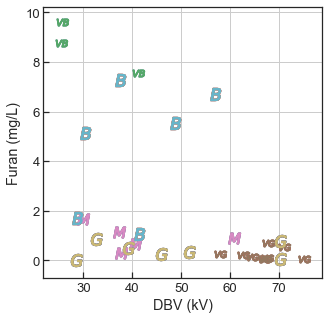

In [21]:
# original transformer data using only two features
plt.figure(figsize=(5,5))
for outcome in data['score'].values:
    plt.scatter(data[data.score == outcome].DBV, data[data.score == outcome].Furan, 
                s=150, marker='${}$'.format(from_class_to_label(outcome)))
plt.grid()
plt.xlabel('DBV (kV)')
plt.ylabel('Furan (mg/L)')
plt.show()

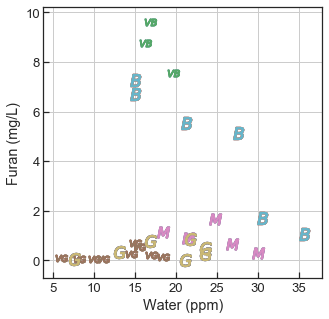

In [22]:
# original transformer data using only two features
plt.figure(figsize=(5,5))
for outcome in data['score'].values:
    plt.scatter(data[data.score == outcome].Water, data[data.score == outcome].Furan, 
                s=150, marker='${}$'.format(from_class_to_label(outcome)))
plt.grid()
plt.xlabel('Water (ppm)')
plt.ylabel('Furan (mg/L)')
plt.show()

### Data preprocessing and splitting

In [23]:
y_t = data[['GRNN']].copy()  # instantiate dataframe for comparisons

In [24]:
# Train data (synthetic)
X_train = syntetic[values]
y_train = syntetic['score'].values
# Test data (actual)
X_test = data[values]
y_test = data['score'].values

In [25]:
# Standardize the input data
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
warnings.filterwarnings(action='ignore', category=ex.DeprecationWarning)

### LogisticRegression for multiclass classification

In [27]:
# Multinomial Logistic Regression (with fixed hyper-parameters)
lreg = LogisticRegression(C=1., solver='newton-cg', multi_class='multinomial')  # fixed "C"
lreg.fit(X_train, y_train)  # fit model to data
y_lr = lreg.predict_proba(X_test)  # predict on new data

In [28]:
y_t['lr'] = y_lr.argmax(axis=1)
y_t['logreg'] = y_t['lr'].apply(from_class_to_label)
del y_t['lr']
y_t

,GRNN,logreg
0,G,G
1,M,B
2,VG,VG
3,B,B
4,VG,VG
5,VG,VG
6,G,G
7,VG,VG
8,VG,VG
9,M,M


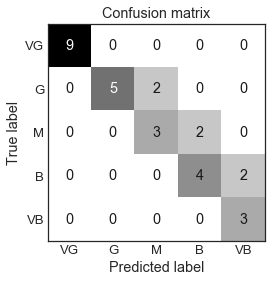

In [29]:
pred = lreg.predict(X_test)
labels = ['VG', 'G', 'M', 'B', 'VB']
# confusion matrix
scores_image = heatmap(metrics.confusion_matrix(y_test, pred), xlabel='Predicted label', 
                       ylabel='True label', xticklabels=labels, yticklabels=labels, 
                       cmap=plt.cm.gray_r, fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()
plt.show()

In [30]:
# classification report
print(metrics.classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

          VG       1.00      1.00      1.00         9
           G       1.00      0.71      0.83         7
           M       0.60      0.60      0.60         5
           B       0.67      0.67      0.67         6
          VB       0.60      1.00      0.75         3

   micro avg       0.80      0.80      0.80        30
   macro avg       0.77      0.80      0.77        30
weighted avg       0.83      0.80      0.80        30



In [31]:
# Grid-search with cross validation for optimal model hyper-parameters
parameters = {'C':[0.01, 0.1, 1., 10., 50., 100.], 
              'multi_class':['multinomial'], 
              'solver':['newton-cg']}
lreg = GridSearchCV(estimator=LogisticRegression(), param_grid=parameters,
                    cv=2, scoring='neg_log_loss', refit=True, n_jobs=1) # refit=True returns the best model
lreg.fit(X_train, y_train)
# Best value of hyper-parameter "C"
best_c = lreg.best_params_['C']
print('Best value: C = {:g}'.format(best_c))

Best value: C = 10


In [32]:
# Average classification accuracy with cross validation
#lreg = LogisticRegression(C=best_c, solver='newton-cg', multi_class='multinomial')
scores = cross_val_score(LogisticRegression(C=best_c, multi_class='multinomial', solver='newton-cg'), 
                         X_train, y_train, cv=3)  # it doesn't return a model
print('Score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Score using 3-fold CV: 0.90162 +/- 0.031357


In [33]:
y_lr = lreg.predict_proba(X_test)
y_t['lr'] = y_lr.argmax(axis=1)
y_t['logreg'] = y_t['lr'].apply(from_class_to_label)
del y_t['lr']

#### Bayesian optimisation for model hyper-parameters selection

In [34]:
try:
    # Model hyper-parameters selection using Bayesian Optimisation
    from bayes_opt import BayesianOptimization
    from bayes_opt.util import Colours
    bayes_optimization = 1
except ImportError:
    bayes_optimization = 0
    print('Install Bayesian Optimization package before executing the next cell.')

In [35]:
if bayes_optimization != 0:
    # Bayesian Optimization with cross-validation for optimal model hyper-parameters selection
    def optimize_logreg(data, targets):
        """Apply Bayesian Optimization to LogisticRegression hyper-parameters."""
        def logreg_cv(C, data, targets):
            """Logistic regression with cross validation."""
            estimator = LogisticRegression(C=C, multi_class='multinomial', solver='newton-cg')
            cval = cross_val_score(estimator, data, targets, scoring='neg_log_loss', cv=2)
            return cval.mean()

        def logreg_crossval(expC):
            """Wrapper of LogisticRegression cross validation.
            Notice how we transform between regular and log scale. While this
            is not technically necessary, it greatly improves the performance
            of the optimizer.
            """
            C = 10 ** expC
            return logreg_cv(C=C, data=data, targets=targets)

        optimizer = BayesianOptimization(f=logreg_crossval, pbounds={'expC': (-3, 2)}, verbose=2)
        optimizer.maximize(n_iter=10)
        return optimizer.max  # dictionary 

    print(Colours.green("--- Optimizing LogisticRegression ---"))
    optimal_params = optimize_logreg(X_train, y_train)
    print(optimal_params)
    print('Optimal value of C: {:.2f}'.format(10.**optimal_params['params']['expC']))

--- Optimizing LogisticRegression ---
|   iter    |  target   |   expC    |
-------------------------------------
|  1        | -0.5083   |  1.894    |
|  2        | -1.094    | -1.484    |
|  3        | -0.615    | -0.3349   |
|  4        | -1.486    | -2.683    |
|  5        | -0.6866   | -0.5516   |
|  6        | -0.3976   |  0.9918   |
|  7        | -0.4086   |  0.7325   |
|  8        | -0.3992   |  1.127    |
|  9        | -0.3975   |  0.9981   |
|  10       | -0.3975   |  1.004    |
|  11       | -0.3975   |  1.004    |
|  12       | -0.3975   |  1.009    |
|  13       | -0.3975   |  1.012    |
|  14       | -0.3975   |  1.012    |
|  15       | -0.3975   |  1.012    |
{'params': {'expC': 1.0124443810203498}, 'target': -0.3974815509116736}
Optimal value of C: 10.29


NOTE: Bayesian optimisation provides a better way of finding optimal model hyper-parameters!

### Support Vector Machines

In [36]:
# Support Vector Machines for multiclass classification
# grid search and cross-validation for hyper-parameters optimisation
parameters = {'C':[0.1, 1., 10., 100]}
clf = GridSearchCV(estimator=SVC(probability=True), param_grid=parameters,  # "rbf" kernel
                   cv=3, scoring='neg_log_loss', refit=True, n_jobs=1)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'C': [0.1, 1.0, 10.0, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='neg_log_loss',
       verbose=0)

In [37]:
best_C = clf.best_params_
scores = cross_val_score(SVC(**best_C), X_train, y_train, cv=3)
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.969907 +/- 0.00163682


In [38]:
y_svm = clf.predict_proba(X_test)
y_t['vm'] = y_svm.argmax(axis=1)
y_t['svm'] = y_t['vm'].apply(from_class_to_label)
del y_t['vm']

### KNeighborsClassifier

In [39]:
parameters = {'n_neighbors':[3, 5, 8, 12]}
# grid search and cross-validation for hyper-parameters optimisation
knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parameters, 
                      cv=3, scoring='neg_log_loss', refit=True, n_jobs=-1) 
knn.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [3, 5, 8, 12]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='neg_log_loss',
       verbose=0)

In [40]:
best_parameters = knn.best_params_
print("Best parameters: {}".format(knn.best_params_))

Best parameters: {'n_neighbors': 12}


In [41]:
scores = cross_val_score(KNeighborsClassifier(**best_parameters), X_train, y_train, cv=3)
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.740741 +/- 0.0526843


In [42]:
y_knn = knn.predict_proba(X_test)
y_t['k'] = y_knn.argmax(axis=1)
y_t['knn'] = y_t['k'].apply(from_class_to_label)
del y_t['k']

### ExtraTreesClassifier

In [43]:
# ExtraTreesClassifier (ensemble learner) with grid search 
# and cross-validation for hyper-parameters optimisation
parameters = {'n_estimators':[5, 10, 15, 20], 
              'criterion':['gini', 'entropy'], 
              'max_depth':[2, 5, None]}
trees = GridSearchCV(estimator=ExtraTreesClassifier(), param_grid=parameters, 
                     cv=3, scoring='neg_log_loss', refit=True, n_jobs=-1) 
trees.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 15, 20], 'criterion': ['gini', 'entropy'], 'max_depth': [2, 5, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [44]:
# Best model parameters
best_parameters = trees.best_params_
print("Best parameters: {}".format(trees.best_params_))

Best parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 5}


In [45]:
scores = cross_val_score(ExtraTreesClassifier(**best_parameters), X_train, y_train, cv=3)
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.920139 +/- 0.0383519


In [46]:
y_trees = trees.predict_proba(X_test)
y_t['t'] = y_trees.argmax(axis=1)
y_t['trees'] = y_t['t'].apply(from_class_to_label)
del y_t['t']

### RandomForest multiclass classifier (ensemble learner)

In [47]:
# RandomForestClassifier (ensemble learner for the multiclass classification)
parameters = {'n_estimators':[10, 15, 20], 
              'criterion':['gini', 'entropy'],
              'max_features':[4, 'auto'],
              'max_depth':[2, None]}
# grid search and cross-validation for hyper-parameters optimisation
forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, 
                      cv=3, scoring='neg_log_loss', refit=True, n_jobs=-1) 
forest.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 15, 20], 'max_features': [4, 'auto'], 'criterion': ['gini', 'entropy'], 'max_depth': [2, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [48]:
best_parameters = forest.best_params_
print("Best parameters: {}".format(forest.best_params_))

Best parameters: {'max_features': 'auto', 'n_estimators': 20, 'criterion': 'entropy', 'max_depth': None}


In [49]:
scores = cross_val_score(RandomForestClassifier(**best_parameters), X_train, y_train, cv=3)
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.969907 +/- 0.00163682


In [50]:
y_forest = forest.predict_proba(X_test)
y_t['f'] = y_forest.argmax(axis=1)
y_t['forest'] = y_t['f'].apply(from_class_to_label)
del y_t['f']

### GradientBoosting multiclass classifier with feature importance analysis

In [51]:
# Train & evaluate model performance
def train_and_evaluate(model, X, y, ns=3):
    # k-fold cross validation iterator 
    cv = KFold(n_splits=ns, shuffle=True)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')  # scoring method is accuracy!
    print('Average score using {:d}-fold CV: {:g} +/- {:g}'.format(ns, np.mean(scores), np.std(scores)))

In [52]:
# Gradient Boosting Classifier
clf_gb = GradientBoostingClassifier()
train_and_evaluate(clf_gb, X_train, y_train, 3)
clf_gb.fit(X_train, y_train)

Average score using 3-fold CV: 0.909982 +/- 0.0247744


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

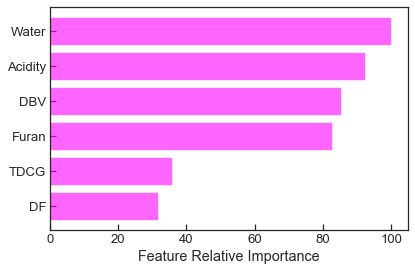

In [53]:
# Feature importance
feature_importance = clf_gb.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# Plot relative feature importance
fig, ax = plt.subplots(figsize=(6,4))
ax.barh(pos, feature_importance[sorted_idx], align='center', color='magenta', alpha=0.6)
plt.yticks(pos, data.columns[sorted_idx])
ax.set_xlabel('Feature Relative Importance')
plt.tight_layout()
plt.show()

In [54]:
# Predict on new data
y_gb = clf_gb.predict_proba(X_test)
y_t['gb'] = y_gb.argmax(axis=1)
y_t['boost'] = y_t['gb'].apply(from_class_to_label)
del y_t['gb']

### Artificial Neural Network for Ordinal Probit Regression

In [55]:
from tensorflow.distributions import Normal as TFNormal

# Probit activation function
def probit(x):
    normal = TFNormal(loc=0., scale=1.)
    return normal.cdf(x)

In [56]:
# Encode 'targets' to categorical variables
y_train_nn = keras.utils.np_utils.to_categorical(y_train)
y_test_nn = keras.utils.np_utils.to_categorical(y_test)

In [57]:
# Keras: Feed-forward artificial neural network
model = keras.models.Sequential()
# Input layer
model.add(keras.layers.Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(keras.layers.Dropout(0.5))  # regularization layer
# hidden layer
model.add(keras.layers.Dense(units=64, activation='tanh'))
model.add(keras.layers.Dropout(0.5))
# hidden layer
model.add(keras.layers.Dense(units=32, activation='tanh'))
model.add(keras.layers.Dropout(0.25))
# *** Add additional hidden layers here ***
# Output layer
# Following line defines Ordinal Probit Regression (ordered categories)
model.add(keras.layers.Dense(units=5, activation=probit))
# Following line defines Softmax Regression (un-ordered categories)
#model.add(keras.layers.Dense(units=5, activation='softmax'))
# Optimizer
adam = keras.optimizers.Adam()
# Compile network
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [58]:
BATCH = 32     # 'batch_size' argument
EPOCHS = 200   # 'epochs' argument

In [59]:
# Fit model on train data
history = model.fit(X_train, y_train_nn, epochs=EPOCHS, batch_size=BATCH, 
                    validation_data=(X_test, y_test_nn), shuffle=True, verbose=0)
# Score metrics (evaluate model on test data)
score = model.evaluate(X_test, y_test_nn, batch_size=BATCH, verbose=0)
print('Log-loss: {:g}, Accuracy: {:.2f} %'.format(score[0], score[1]*100))

Log-loss: 0.69338, Accuracy: 76.67 %


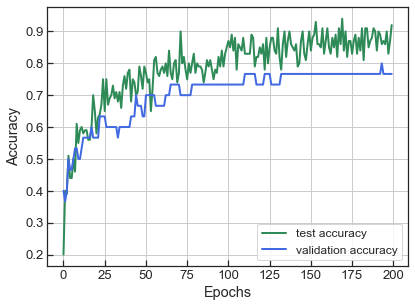

In [60]:
hist = history.history
acc = hist['acc']
acc_val = hist['val_acc']
fig, ax = plt.subplots(figsize=(6,4.5))
ax.plot(acc, ls='-', lw=2, c='seagreen', label='test accuracy')
ax.plot(acc_val, ls='-', lw=2, c='royalblue', label='validation accuracy')
ax.grid()
ax.legend(loc='best', fontsize=12)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [61]:
# Predict class probability on test data
y_pred_proba_nn = model.predict_proba(X_test, batch_size=BATCH, verbose=0)
y_t['k'] = y_pred_proba_nn.argmax(axis=1)
y_t['keras'] = y_t['k'].apply(from_class_to_label)
del y_t['k']

## Ensemble models using voting principle

<p style="background-color:honeydew;padding:10px;border:2px solid mediumseagreen"><b>Note:</b> Ensembling consists of pooling together the predictions of a set of different models, to produce better predictions. The key to making ensembling work is the diversity of the set of classifiers. Diversity is what makes ensembling work. For this reason, one should ensemble models that are as good as possible while being <b>as different as possible</b>. This typically means using very different network architectures or even different brands of machine-learning approaches. This is exactly what has been proposed here.</p>

### Hard voting

In [62]:
clf = VotingClassifier(estimators=[('logreg', lreg),     # LogisticRegression
                                   ('KNN', knn),         # KNeighbors
                                   ('trees', trees),     # ExtraTrees
                                   ('forest', forest)],  # RandomForrest 
                       weights=[2, 1, 3, 2],  # classifier relative weights
                       voting='hard')
clf = clf.fit(X_train, y_train)

In [63]:
y_t['clf'] = clf.predict(X_test)
y_t['hard_vote'] = y_t['clf'].apply(from_class_to_label)
del y_t['clf']

In [64]:
scores = cross_val_score(clf, X_train, y_train, cv=3)
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.969907 +/- 0.00163682


### Soft voting

In [65]:
clf = VotingClassifier(estimators=[('logreg', lreg),    # LogisticRegression
                                   ('KNN', knn),        # KNeighbors
                                   ('trees', trees)],   # ExtraTrees 
                       weights=[2, 1, 3],  # classifier relative weights
                       voting='soft')
clf = clf.fit(X_train, y_train)

In [66]:
y_clf = clf.predict_proba(X_test)
y_t['clf'] = y_clf.argmax(axis=1)
y_t['soft_vote'] = y_t['clf'].apply(from_class_to_label)
del y_t['clf']

In [67]:
scores = cross_val_score(clf, X_train, y_train, cv=3)
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.949074 +/- 0.0163682


#### Predictions using individual classifiers and ensembles

In [68]:
y_t

,GRNN,logreg,svm,knn,trees,forest,boost,keras,hard_vote,soft_vote
0,G,G,G,G,G,G,G,G,G,G
1,M,M,M,B,M,M,M,B,M,M
2,VG,VG,VG,VG,VG,VG,VG,VG,VG,VG
3,B,B,B,B,B,B,B,B,B,B
4,VG,VG,VG,VG,VG,VG,VG,VG,VG,VG
5,VG,VG,VG,VG,VG,VG,VG,VG,VG,VG
6,G,G,G,VG,G,G,G,G,G,G
7,VG,VG,VG,VG,VG,VG,VG,VG,VG,VG
8,VG,VG,VG,VG,VG,VG,VG,VG,VG,VG
9,M,M,M,M,M,M,M,B,M,M


<p style="background-color:honeydew;padding:10px;border:2px solid mediumseagreen"><b>Note:</b> Reported model accuracy depends on the random synthetic dataset used during the learning phase, which has been generated from the original dataset (used for testing) by means of the simple "data augmentation" technique. Possibility for overfitting and underfitting should be further examined, preferably with a larger dataset.</p>

In [69]:
import sys, IPython, platform, sklearn
print("Notebook createad on {:s} computer running {:s} and using:\
      \nPython {:s}\nIPython {:s}\nScikit-learn {:s}\nPandas {:s}\nNumpy {:s}\n"\
      .format(platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], 
              IPython.__version__, sklearn.__version__, pd.__version__, np.__version__))

Notebook createad on x86_64 computer running debian buster/sid and using:      
Python 2.7.1
IPython 5.8.0
Scikit-learn 0.20.1
Pandas 0.23.4
Numpy 1.15.4

